In [3]:
import torch # we are going to use pytorch instead of numpy because it's much faster.
import torch.nn as nn
from ignite.contrib.metrics.regression import R2Score
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.datasets import make_spd_matrix
from scipy.optimize import minimize
from scipy.linalg import toeplitz
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse, r2_score as R2

In [4]:
device = torch.device("cuda")
dtype = torch.float64

# Define Scalers
*   StandardScaler
*   MinMax



In [5]:
class StandardScaler:
    def __init__(self):
        self.mean = None
        self.std = None

    def fit(self, data):
        """
        Compute the minimum and maximum value of the data for scaling.

        Args:
        - data (torch.Tensor): Input data tensor.
        """
        self.mean = torch.mean(data, dim=0, keepdim=True)
        self.std = torch.std(data, dim=0, keepdim=True)+1e-10

    def transform(self, data):
        """
        Scale the data based on the computed minimum and maximum values.

        Args:
        - data (torch.Tensor): Input data tensor.

        Returns:
        - torch.Tensor: Scaled data tensor.
        """
        if self.mean is None or self.std is None:
            raise ValueError("Scaler has not been fitted yet. Please call 'fit' with appropriate data.")

        scaled_data = (data - self.mean) / (self.std)
        return scaled_data

    def fit_transform(self, data):
        """
        Fit to data, then transform it.

        Args:
        - data (torch.Tensor): Input data tensor.

        Returns:
        - torch.Tensor: Scaled data tensor.
        """
        self.fit(data)
        return self.transform(data)

In [6]:
class MinMaxScaler:
    def __init__(self):
        self.min = None
        self.max = None

    def fit(self, data):
        """
        Compute the minimum and maximum value of the data for scaling.

        Args:
        - data (torch.Tensor): Input data tensor.
        """
        self.min = torch.min(data, dim=0, keepdim=True).values
        self.max = torch.max(data, dim=0, keepdim=True).values

    def transform(self, data):
        """
        Scale the data based on the computed minimum and maximum values.

        Args:
        - data (torch.Tensor): Input data tensor.

        Returns:
        - torch.Tensor: Scaled data tensor.
        """
        if self.min is None or self.max is None:
            raise ValueError("Scaler has not been fitted yet. Please call 'fit' with appropriate data.")

        scaled_data = (data - self.min) / (self.max - self.min)
        return scaled_data

    def fit_transform(self, data):
        """
        Fit to data, then transform it.

        Args:
        - data (torch.Tensor): Input data tensor.

        Returns:
        - torch.Tensor: Scaled data tensor.
        """
        self.fit(data)
        return self.transform(data)

# Define Regressors
*   Elastic Net
*   PED_SGD
*   PED_Adam
*   PED_LBFGS




In [10]:
class ElasticNet(nn.Module):
    def __init__(self, input_size, alpha=1.0, l1_ratio=0.5):
        """
        Initialize the ElasticNet regression model.

        Args:
            input_size (int): Number of input features.
            alpha (float): Regularization strength. Higher values of alpha
                emphasize L1 regularization, while lower values emphasize L2 regularization.
            l1_ratio (float): The ratio of L1 regularization to the total
                regularization (L1 + L2). It should be between 0 and 1.

        """
        super(ElasticNet, self).__init__()
        self.input_size = input_size
        self.alpha = alpha
        self.l1_ratio = l1_ratio

        # Define the linear regression layer
        self.linear = nn.Linear(input_size, 1).double()

    def forward(self, x):
        """
        Forward pass of the ElasticNet model.

        Args:
            x (Tensor): Input data with shape (batch_size, input_size).

        Returns:
            Tensor: Predicted values with shape (batch_size, 1).

        """
        return self.linear(x)

    def loss(self, y_pred, y_true):
        """
        Compute the ElasticNet loss function.

        Args:
            y_pred (Tensor): Predicted values with shape (batch_size, 1).
            y_true (Tensor): True target values with shape (batch_size, 1).

        Returns:
            Tensor: The ElasticNet loss.

        """
        mse_loss = nn.MSELoss()(y_pred, y_true)
        l1_reg = torch.norm(self.linear.weight, p=1)
        l2_reg = torch.norm(self.linear.weight, p=2)

        loss = mse_loss + self.alpha * (
            self.l1_ratio * l1_reg + (1 - self.l1_ratio) * l2_reg
        )

        return loss

    def fit(self, X, y, num_epochs=100, learning_rate=0.01):
        """
        Fit the ElasticNet model to the training data.

        Args:
            X (Tensor): Input data with shape (num_samples, input_size).
            y (Tensor): Target values with shape (num_samples, 1).
            num_epochs (int): Number of training epochs.
            learning_rate (float): Learning rate for optimization.

        """
        optimizer = optim.SGD(self.parameters(), lr=learning_rate)

        for epoch in range(num_epochs):
            self.train()
            optimizer.zero_grad()
            y_pred = self(X)
            loss = self.loss(y_pred, y)
            loss.backward()
            optimizer.step()

            if (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}")

    def predict(self, X):
        """
        Predict target values for input data.

        Args:
            X (Tensor): Input data with shape (num_samples, input_size).

        Returns:
            Tensor: Predicted values with shape (num_samples, 1).

        """
        self.eval()
        with torch.no_grad():
            y_pred = self(X)
        return y_pred
    def get_coefficients(self):
        """
        Get the coefficients (weights) of the linear regression layer.

        Returns:
            Tensor: Coefficients with shape (output_size, input_size).

        """
        return self.linear.weight


In [7]:
class SqrtLasso(nn.Module):
    def __init__(self, input_size, alpha=0.1):
        """
        Initialize the  regression model.


        """
        super(SqrtLasso, self).__init__()
        self.input_size = input_size
        self.alpha = alpha


        # Define the linear regression layer
        self.linear = nn.Linear(input_size, 1,bias=False,device=device,dtype=dtype)

    def forward(self, x):
        """
        Forward pass of the model.

        Args:
            x (Tensor): Input data with shape (batch_size, input_size).

        Returns:
            Tensor: Predicted values with shape (batch_size, 1).

        """
        return self.linear(x)

    def loss(self, y_pred, y_true):
        """
        Compute the loss function.

        Args:
            y_pred (Tensor): Predicted values with shape (batch_size, 1).
            y_true (Tensor): True target values with shape (batch_size, 1).

        Returns:
            Tensor: The loss.

        """
        mse_loss = nn.MSELoss(reduction='mse')(y_pred, y_true)
        l1_reg = torch.norm(self.linear.weight, p=1,dtype=torch.float64)
        # l2_reg = torch.norm(self.linear.weight, p=2,dtype=torch.float64)

        loss = torch.sqrt(mse_loss) + self.alpha * (l1_reg)

        return loss

    def fit(self, X, y, num_epochs=200, learning_rate=0.01):
        """
        Fit the model to the training data.

        Args:
            X (Tensor): Input data with shape (num_samples, input_size).
            y (Tensor): Target values with shape (num_samples, 1).
            num_epochs (int): Number of training epochs.
            learning_rate (float): Learning rate for optimization.

        """
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)

        for epoch in range(num_epochs):
            self.train()
            optimizer.zero_grad()
            y_pred = self(X)
            loss = self.loss(y_pred, y)
            loss.backward()
            optimizer.step()

            if (epoch + 1) % 100 == 0:
                print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}")

    def predict(self, X):
        """
        Predict target values for input data.

        Args:
            X (Tensor): Input data with shape (num_samples, input_size).

        Returns:
            Tensor: Predicted values with shape (num_samples, 1).

        """
        self.eval()
        with torch.no_grad():
            y_pred = self(X)
        return y_pred
    def get_coefficients(self):
        """
        Get the coefficients (weights) of the linear regression layer.

        Returns:
            Tensor: Coefficients with shape (output_size, input_size).

        """
        return self.linear.weight

# Simulate Data

In [12]:
# we want to define a function for generating x with a prescribed number of obsvervations, features and Toeplitz correlation structure.
def make_correlated_features(num_samples,p,rho):
  vcor = [] 
  for i in range(p):
    vcor.append(rho**i)
  r = toeplitz(vcor)
  mu = np.repeat(0,p)
  x = np.random.multivariate_normal(mu, r, size=num_samples)
  return x

In [13]:
rho =0.9
p = 20
n = 150
vcor = []
for i in range(p):
  vcor.append(rho**i)

In [14]:
x = make_correlated_features(n,p,rho)

In [16]:
beta =np.array([-1,2,3,0,0,0,0,2,-1,4])
beta = beta.reshape(-1,1)
betas = np.concatenate([beta,np.repeat(0,p-len(beta)).reshape(-1,1)],axis=0)

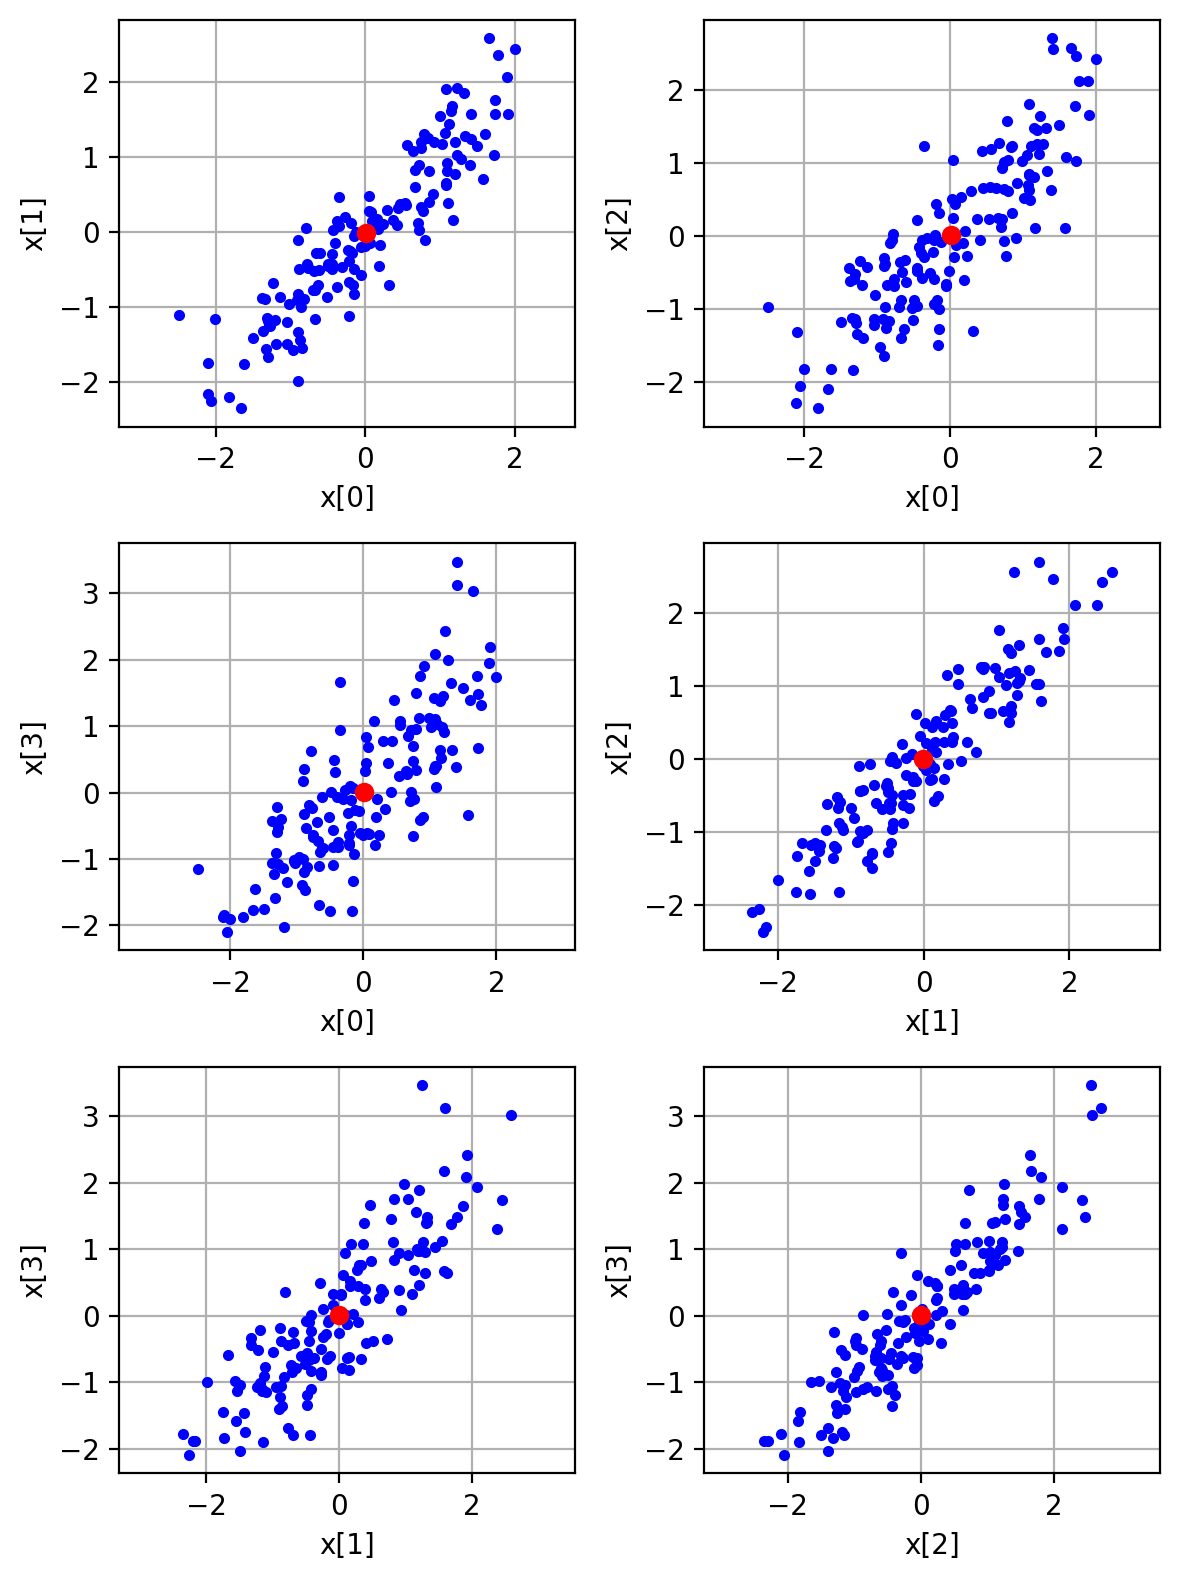

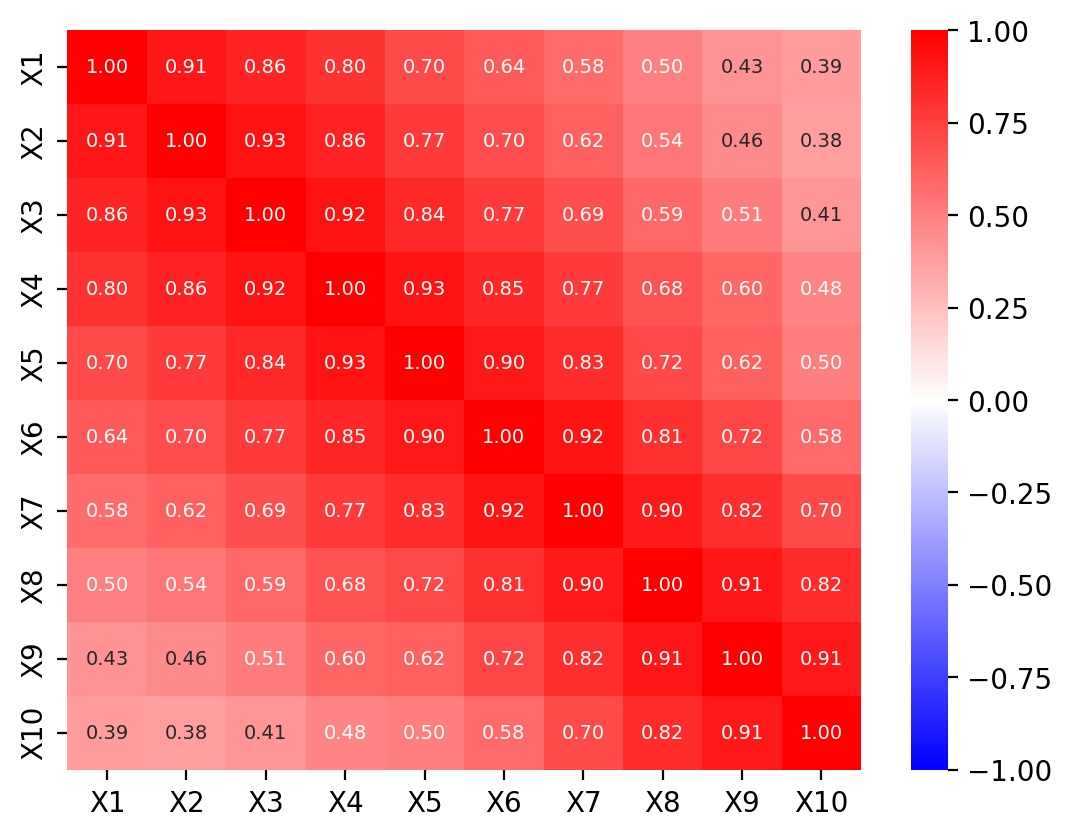

In [19]:


mu = np.mean(x,axis=0)

fig, ax = plt.subplots(nrows=3, ncols=2,figsize=(6,8))


plt.subplot(3,2,1)
plt.plot(x[:,0], x[:,1], 'b.')
plt.plot(mu[0], mu[1], 'ro')
plt.xlabel('x[0]')
plt.ylabel('x[1]')
plt.axis('equal')
plt.grid(True)

plt.subplot(3,2,2)
plt.plot(x[:,0], x[:,2], 'b.')
plt.plot(mu[0], mu[2], 'ro')
plt.xlabel('x[0]')
plt.ylabel('x[2]')
plt.axis('equal')
plt.grid(True)

plt.subplot(3,2,3)
plt.plot(x[:,0], x[:,3], 'b.')
plt.plot(mu[0], mu[3], 'ro')
plt.xlabel('x[0]')
plt.ylabel('x[3]')
plt.axis('equal')
plt.grid(True)

plt.subplot(3,2,4)
plt.plot(x[:,1], x[:,2], 'b.')
plt.plot(mu[1], mu[2], 'ro')
plt.xlabel('x[1]')
plt.ylabel('x[2]')
plt.axis('equal')
plt.grid(True)

plt.subplot(3,2,5)
plt.plot(x[:,1], x[:,3], 'b.')
plt.plot(mu[1], mu[3], 'ro')
plt.xlabel('x[1]')
plt.ylabel('x[3]')
plt.axis('equal')
plt.grid(True)

plt.subplot(3,2,6)
plt.plot(x[:,2], x[:,3], 'b.')
plt.plot(mu[2], mu[3
                   ], 'ro')
plt.xlabel('x[2]')
plt.ylabel('x[3]')
plt.axis('equal')
plt.grid(True)
fig.tight_layout()
plt.show()
cols = ['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10']

# mind the transpose of x
# here we look at the correlations among the first 10 features
sns.heatmap(np.corrcoef(np.transpose(x[:,:10])),cmap='bwr',vmin=-1,vmax=1,annot=True,fmt='.2f',annot_kws={"size": 7},xticklabels=cols,yticklabels=cols)
plt.show()